# DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

## Tensors

https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html

In [ ]:
import torch

In [ ]:
x = torch.empty(5, 3)
x

In [ ]:
x = torch.rand(5, 3)
x

In [ ]:
x = torch.zeros(5, 3, dtype=torch.long)
x

In [ ]:
x = torch.tensor([5.5, 3])
x

In [ ]:
x = x.new_ones(5, 3, dtype=torch.double)      # new_* methods take in sizes
x

In [ ]:
x = torch.randn_like(x, dtype=torch.float)    # override dtype!
x                                     # result has the same size

In [ ]:
print(x.size())

In [ ]:
y = torch.rand(5, 3)
print(x + y)

In [ ]:
print(torch.add(x, y))

In [ ]:
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

In [ ]:
y.add_(x)
print(y)

In [ ]:
print(x[:, 1])

In [ ]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

In [ ]:
x = torch.randn(1)
print(x)
print(x.item())

In [ ]:
a = torch.ones(5)
print(a)

In [ ]:
b = a.numpy()
print(b)

In [ ]:
a.add_(1)
print(a)
print(b)

In [ ]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

In [ ]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

## AUTOGRAD: AUTOMATIC DIFFERENTIATION

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

In [ ]:
y = x + 2
print(y)

In [ ]:
y.backward()
y.grad

In [ ]:
print(y.grad_fn)

In [ ]:
z = y * y * 3
print(z)
out = z.mean()

print(z, out)

In [ ]:
out.backward()

In [ ]:
out

In [ ]:
x.grad

In [ ]:
y.grad

In [ ]:
z.grad

In [ ]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

In [ ]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

In [ ]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

In [ ]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

## NEURAL NETWORKS

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

### Define the network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

In [ ]:
params = list(net.parameters())
for i, param in enumerate(params):
    print(i+1, param.size())  # conv1's .weight

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Loss function

In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### Backprop

In [ ]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

### Update the weights

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

or

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

## TRAINING AN IMAGE CLASSIFIER

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Load and normalize the CIFAR10 training and test datasets using torchvision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [6]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Get some random training images

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [16]:
images[0].shape

torch.Size([3, 32, 32])

Show images

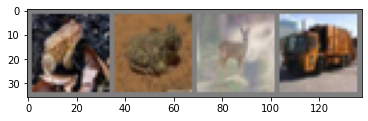

In [13]:
imshow(torchvision.utils.make_grid(images))

Print labels

In [12]:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 frog  frog  deer truck


### Define a Convolutional Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define a loss function

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network on the training data

In [18]:
history=[]

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history.append(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.862
[1,  6000] loss: 1.693
[1,  8000] loss: 1.591
[1, 10000] loss: 1.504
[1, 12000] loss: 1.459
[2,  2000] loss: 1.372
[2,  4000] loss: 1.344
[2,  6000] loss: 1.328
[2,  8000] loss: 1.296
[2, 10000] loss: 1.255
[2, 12000] loss: 1.237
Finished Training


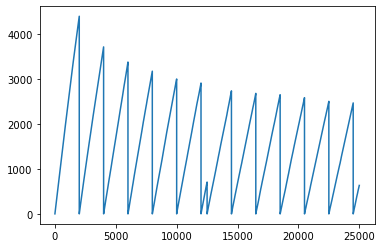

In [75]:
%matplotlib inline
from matplotlib.pylab import *
plot(history);

In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

https://stackoverflow.com/questions/39035983/compress-zip-numpy-arrays-in-memory

In [61]:
import numpy as np    
import zlib

def compression_ratio_np(A):
    B = zlib.compress(A, 1)
    BZ = zlib.compress(A,0)
    return len(B)/len(BZ)

def compression_ratio(T):
    return compression_ratio_np(T.numpy())

def byte_size(a):
    return a.element_size() * a.nelement()

import pandas as pd
D=net.state_dict()
rows=[]
for x in D:
    a=D[x]
    rows.append([x, a.shape, byte_size(a), compression_ratio(a)])
pd.DataFrame(rows, columns=['Parameter', 'Shape', 'Size', 'Compression Ratio'])

### Test the network on the test data

In [77]:
dataiter = iter(testloader)
images, labels = dataiter.next()

https://discuss.pytorch.org/t/what-is-the-correct-way-of-using-trchvision-utils-make-grid/55117/4

Print images

In [83]:
x=torchvision.utils.make_grid(images)
x.min(), x.max()

(tensor(-1.), tensor(1.))

In [84]:
M=x.numpy().transpose(1,2,0)
M.min(), M.max()

(-1.0, 1.0)

In [85]:
M=(M+1)/2
M.min(),M.max()

(0.0, 1.0)

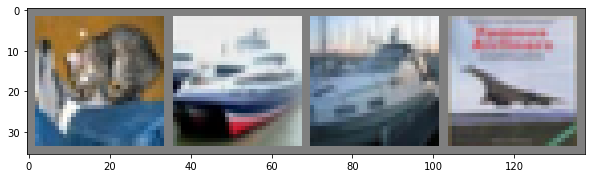

In [89]:
figure(figsize=(10,4))
imshow(M);

In [90]:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  cat  ship  ship plane


In [91]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [93]:
outputs = net(images)
outputs.shape

torch.Size([4, 10])

In [94]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [95]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [96]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 77 %
Accuracy of  bird : 41 %
Accuracy of   cat : 29 %
Accuracy of  deer : 37 %
Accuracy of   dog : 65 %
Accuracy of  frog : 75 %
Accuracy of horse : 65 %
Accuracy of  ship : 70 %
Accuracy of truck : 53 %


## Training on GPU

In [102]:
import torch
dtype = torch.float
device = torch.device("cuda:0") # Uncomment this to run on GPU
device

device(type='cuda', index=0)

In [116]:
net=Net()
net.load_state_dict(torch.load(PATH))
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [119]:
history=[]

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history.append(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.182
[1,  4000] loss: 1.172
[1,  6000] loss: 1.150
[1,  8000] loss: 1.139
[1, 10000] loss: 1.148
[1, 12000] loss: 1.129
[2,  2000] loss: 1.052
[2,  4000] loss: 1.062
[2,  6000] loss: 1.065
[2,  8000] loss: 1.061
[2, 10000] loss: 1.085
[2, 12000] loss: 1.041
Finished Training


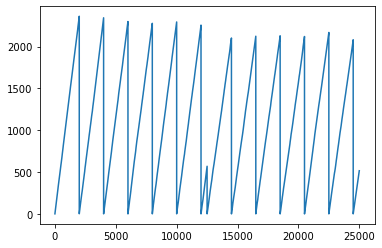

In [120]:
plot(history)

In [123]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels  = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %
